### Import dependencies 

In [2]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

### Import data

In [3]:
df = pd.read_csv('SMSSpamCollection.csv',sep='\t',header=None)

### Nettoyage 

In [4]:
df.columns = ['label', 'msg']
df.head(2)

,label,msg
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [5]:
lemmatizer = WordNetLemmatizer()
regex = re.compile("\d+")

def clean_text(text):
    #lower text
    text = text.lower()
    #remove numbers
    text = regex.sub("", text)
    #text with no punctuation
    text = "".join(c for c in text if c not in string.punctuation)
    #tokenize words
    text_token = word_tokenize(text)
    #delete stop words+words with lentgh >2
    text_sp = [word for word in text_token if word not in nltk.corpus.stopwords.words('english') and len(word)>2]
    #stemming
    text_stem = [lemmatizer.lemmatize(word) for word in text_sp]
    text_out = " ".join(text_stem)
    return text_out

In [6]:
print(df['msg'][0])
print("-"*50)
print(clean_text(df['msg'][0]))

I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.
--------------------------------------------------
ive searching right word thank breather promise wont take help granted fulfil promise wonderful blessing time


#### let's apply this on our dataframe 

In [7]:
df['clean_msg'] = df['msg'].apply(clean_text)
df.head(2)

,label,msg,clean_msg
0,ham,I've been searching for the right words to tha...,ive searching right word thank breather promis...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...


### EDA: Exploratory data analysis

#### Word Cloud for "spam" msg

In [8]:
spam_messages = df[df['label'] == 'spam']['clean_msg']
ham_messages = df[df['label'] == 'ham']['clean_msg']

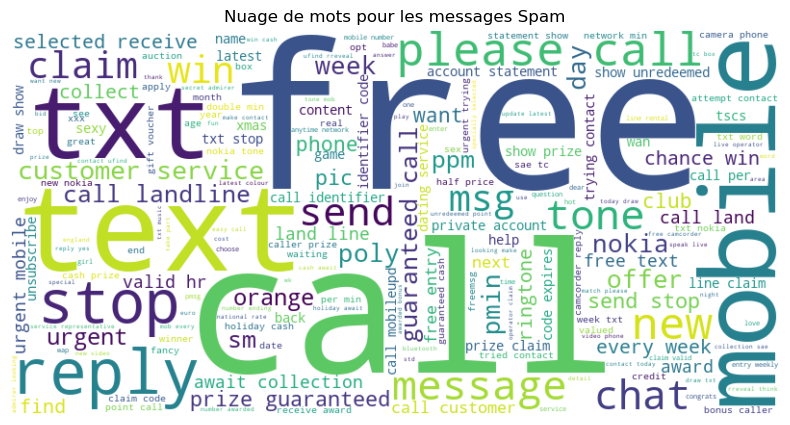

In [9]:
# Créer un nuage de mots pour les messages Spam
spam_cloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(spam_messages))

plt.figure(figsize=(10, 5))
plt.imshow(spam_cloud, interpolation='bilinear')
plt.title("Nuage de mots pour les messages Spam")
plt.axis('off')  
plt.show()

#### Analyser la frequence des mots 

In [10]:
from collections import Counter

spam_word_counts = Counter(" ".join(spam_messages).split())
ham_word_counts = Counter(" ".join(ham_messages).split())

print("Mots les plus fréquents dans les messages Spam:", spam_word_counts.most_common(10))
print("Mots les plus fréquents dans les messages Ham:", ham_word_counts.most_common(10))

Mots les plus fréquents dans les messages Spam: [('call', 361), ('free', 219), ('txt', 150), ('text', 138), ('mobile', 136), ('stop', 118), ('claim', 115), ('reply', 103), ('prize', 94), ('get', 83)]
Mots les plus fréquents dans les messages Ham: [('get', 318), ('ltgt', 276), ('dont', 265), ('come', 245), ('got', 244), ('call', 243), ('know', 241), ('ill', 238), ('like', 234), ('good', 225)]


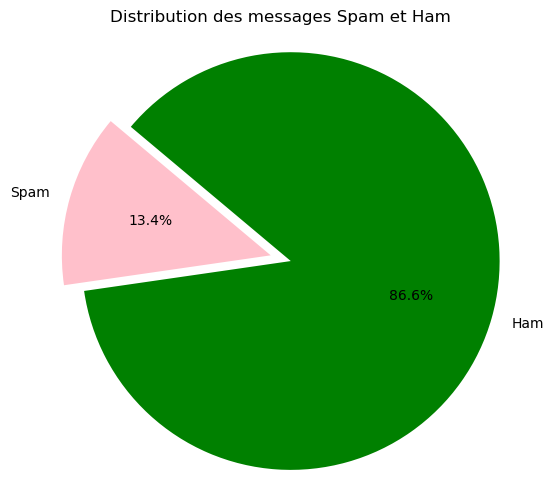

In [11]:
spam_count = df[df['label'] == 'spam']['label'].count()
ham_count = df[df['label'] == 'ham']['label'].count()
 
explode = (0.1, 0) 

plt.figure(figsize=(6, 6))
plt.pie([spam_count, ham_count], labels=['Spam', 'Ham'], colors=['pink', 'green'], explode=explode, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Pour que le graphique soit un cercle

plt.title("Distribution des messages Spam et Ham")
plt.show()

## TF-IDF 

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 3))  

features_tfidf = tfidf.fit_transform(df['clean_msg'])
features_df = pd.DataFrame(features_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [13]:
features_df.head(1)

,aah,aah bless,aah bless hows,aah cuddle,aah cuddle would,aah speak,aah speak tomo,aaniye,aaniye pudunga,aaniye pudunga venaam,...,zyada kisi kuch,üll,üll finish,üll finish buying,üll submitting,üll submitting project,üll take,üll take forever,〨ud,〨ud evening
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train Test split

In [14]:
X = features_df
y = pd.get_dummies(df.label, drop_first=True)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

# Choix du modele 

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("F1_score", f1_score(y_pred_svm,y_test))
print("Accuracy ", accuracy_score(y_pred_svm,y_test))
print("Recall ", recall_score(y_pred_svm,y_test))
print("Precision ", precision_score(y_pred_svm,y_test))

C:\Users\HP\anaconda3\envs\MDS\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1_score 0.728476821192053
Accuracy  0.9410919540229885
Recall  0.990990990990991
Precision  0.5759162303664922


## Comment peut on ameliorer l'accuracy

#### Nb de ponctuation: est ce que la ponctuation impacte le resultat?

In [18]:
def nb_ponctuation(texte):
    cpt = 0
    for c in texte:
        if c in string.punctuation:
            cpt += 1
    return cpt

In [19]:
df['punct'] = df.msg.apply(nb_ponctuation)
df.head(1)

,label,msg,clean_msg,punct
0,ham,I've been searching for the right words to tha...,ive searching right word thank breather promis...,4


#### Nb de noms propres: est ce que les noms propres impacte le resultat?

In [20]:
def nom_propre(texte):
    tokens = nltk.word_tokenize(texte)
    tagged = nltk.pos_tag(tokens)
    nomspropres = [word for word, pos in tagged if pos == 'NNP']
    return len(nomspropres)

In [21]:
df['nb_words'] = df.msg.apply(nom_propre)
df.head(2)

,label,msg,clean_msg,punct,nb_words
0,ham,I've been searching for the right words to tha...,ive searching right word thank breather promis...,4,0
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...,6,6


#### la taille du message : est ce que la taille dun message impacte le resultat?

In [22]:
df['taille'] = df.msg.apply(lambda txt:len(txt))
df.head(2)

,label,msg,clean_msg,punct,nb_words,taille
0,ham,I've been searching for the right words to tha...,ive searching right word thank breather promis...,4,0,196
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win cup final tkts may te...,6,6,155


In [23]:
df2 = df.iloc[:,-3:]
df2.head(2)

,punct,nb_words,taille
0,4,0,196
1,6,6,155


In [24]:
df2.describe()

,punct,nb_words,taille
count,5568.000000,5568.000000,5568.000000
mean,4.175287,1.844109,80.487428
std,4.624715,3.422489,59.950961
min,0.000000,0.000000,2.000000
25%,2.000000,0.000000,36.000000
50%,3.000000,1.000000,62.000000
75%,6.000000,2.000000,122.000000
max,133.000000,42.000000,910.000000


#### Scale the dataframe with the new columns 

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Minmaxscaled = MinMaxScaler().fit_transform(df2)
print(Minmaxscaled)

[[0.03007519 0.         0.21365639]
 [0.04511278 0.14285714 0.1685022 ]
 [0.01503759 0.02380952 0.06497797]
 ...
 [0.05263158 0.         0.06057269]
 [0.0075188  0.         0.13546256]
 [0.0075188  0.02380952 0.02643172]]


In [26]:
scaled_df = pd.DataFrame(Minmaxscaled, columns=df2.columns)
scaled_df.head(2)

,punct,nb_words,taille
0,0.030075,0.000000,0.213656
1,0.045113,0.142857,0.168502


In [27]:
X.head(1)

,aah,aah bless,aah bless hows,aah cuddle,aah cuddle would,aah speak,aah speak tomo,aaniye,aaniye pudunga,aaniye pudunga venaam,...,zyada kisi kuch,üll,üll finish,üll finish buying,üll submitting,üll submitting project,üll take,üll take forever,〨ud,〨ud evening
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X_new = pd.concat([scaled_df, X], axis=1)

In [29]:
X_new.head(1)

,punct,nb_words,taille,aah,aah bless,aah bless hows,aah cuddle,aah cuddle would,aah speak,aah speak tomo,...,zyada kisi kuch,üll,üll finish,üll finish buying,üll submitting,üll submitting project,üll take,üll take forever,〨ud,〨ud evening
0,0.030075,0.0,0.213656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, stratify=y, test_size=0.25) 

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4176, 64039)
(4176, 1)
(1392, 64039)
(1392, 1)


In [35]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("F1_score", f1_score(y_pred_svm,y_test))
print("Accuracy ", accuracy_score(y_pred_svm,y_test))
print("Recall ", recall_score(y_pred_svm,y_test))
print("Precision ", precision_score(y_pred_svm,y_test))

C:\Users\HP\anaconda3\envs\MDS\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1_score 0.847560975609756
Accuracy  0.9640804597701149
Recall  0.9858156028368794
Precision  0.7433155080213903


The accuracy is better as we see, still can be improved tho

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300) #we improved it a little by changing hyperparameters
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("F1_score", f1_score(y_pred_rf,y_test))
print("Accuracy ", accuracy_score(y_pred_rf,y_test))
print("Recall ", recall_score(y_pred_rf,y_test))
print("Precision ", precision_score(y_pred_rf,y_test))

C:\Users\HP\AppData\Local\Temp\ipykernel_18740\52314681.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


F1_score 0.8734177215189874
Accuracy  0.9712643678160919
Recall  1.0
Precision  0.7752808988764045


Lets choose random forest finally. It's the highest accuracy

# Evaluation du modele choisi

#### Matrice de confusion 

<AxesSubplot:>

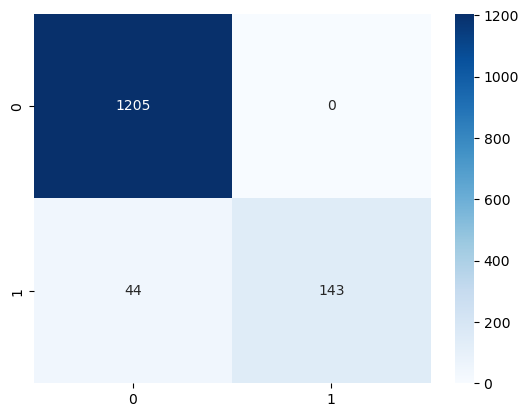

In [41]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,y_pred_rf), annot=True, fmt="d", cmap="Blues")

Un score F1 élevé indique un bon équilibre entre la précision et le rappel de votre modèle. C'est un indicateur solide de la capacité du modèle à classer à la fois les vrais positifs et les vrais négatifs, tout en minimisant les faux positifs et les faux négatifs.

Une accuracy élevée signifie que votre modèle prédit correctement la grande majorité des exemples. Cependant, l'accuracy peut être biaisée si les classes sont déséquilibrées, alors assurez-vous que l'ensemble de données est équilibré en conséquence.

Un rappel de 1.0 signifie que votre modèle identifie correctement tous les exemples positifs (spam) dans l'ensemble de test. C'est un excellent résultat pour la capacité du modèle à "rappeler" les vrais positifs.

La précision de 0.792 indique que 79.2% des prédictions de spam faites par le modèle sont correctes. Cela signifie qu'il y a un certain nombre de faux positifs, mais c'est un compromis acceptable en fonction de votre seuil de tolérance aux faux positifs.